In [394]:
import numpy as np
import pandas as pd

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df != "******").all(axis=1)]
    
    col_map = {
        "długośćmm": "dlugoscmm",
        "szerokośćmm": "szerokoscmm",
        "kąt": "kat",
        "obwódmm": "obwodmm",
        "średnica_fereta_hmm": "srednica_fereta_hmm",
        "średn._martinamm": "sredn._martinamm",
        "średn._sitowamm": "sredn._sitowamm",
        "średnia_jaskrawość": "srednia_jaskrawosc"
    }

    if "długośćmm" in df.columns:
        df = df.rename(columns=col_map)
        if "szerokoscmm" in df.columns:
            df["szerokoscmm"] = df["szerokoscmm"].astype(np.float64)

    return df


In [395]:
import os
import pandas as pd

def load_dfs_from_path(path="example"):

    combined_df = []

    for entry in os.scandir(path):  
        if entry.is_file() and entry.name.endswith(".csv"):
            df = pd.read_csv(entry.path)
            df = preprocess_df(df)
            combined_df.append(df)

    combined_df = pd.concat(combined_df, ignore_index=True)

    return combined_df

In [396]:
def get_individual_stats(df):
    df = preprocess_df(df)
    # Scaling
    df['dlugoscmm'] = df['dlugoscmm']/1.49
    df['szerokoscmm'] = df['szerokoscmm']/1.49
    df['powierzchniamm'] = df['powierzchniamm']/2.235

    # filtering the things that with high probability are not bacteria !TODO odkomentuj to po testach
    # df = df[df['dlugoscmm'] >= 0.2]
    # df = df[df['szerokoscmm'] <= 1.5]

    df['Pw'] = 3.14*(df['szerokoscmm']/2)**2+df['szerokoscmm']*(df['dlugoscmm']-df['szerokoscmm'])
    df['R'] = df['Pw'] / df['powierzchniamm']
    df['Dk'] = df['dlugoscmm']
    df['Sk'] = df['szerokoscmm']
    df['D/S'] = (df['Dk'] / df['Sk']).astype('float64')

    bacteria_types = []
    Dks = []
    Sks = []
    for idx,row  in df.iterrows():
        if row['dlugoscmm'] < 0.2 or row['szerokoscmm'] > 1.5:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            bacteria_types.append("Removed_dim")
        elif row['R'] > 1.2:
            Dks.append(row['szerokoscmm'])
            Sks.append(row['Pw']*0.8)
            bacteria_types.append("Krzywe")
        else:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            if round(row['D/S'],15) > 1.5:
                bacteria_types.append("Pałeczki")
            else:
                bacteria_types.append("Ziarniaki")
    df['bacteria_type'] = bacteria_types
    df['Dk'] = Dks
    df['Sk'] = Sks

    df['Ob'] =(3.14*(df['Sk']**3)/6)+(3.14*((df['Sk']**2)/4)*(df['Dk']-df['Sk']))
    # !TODO remove this
    # df = df[df['Ob']>0]
    df.loc[df['Ob'] <= 0, 'bacteria_type'] = "removed_ob"
    df['Ob'] = np.abs(df['Ob'])
    # -----------------

    df['bialko'] = 104.5 * (df['Ob']**0.59)
    df['wegiel'] = 0.86 * df['bialko']

    return df

In [397]:
def get_stats_for_bacteria_types(df,probe_volume_ml = 6):
    grouped = df.groupby("bacteria_type")
    result_count = grouped.size().reset_index(name="count")
    result = grouped["Ob"].mean().reset_index()

    result['bialko'] = 104.5 * (result['Ob']**0.59)
    result['wegiel'] = 0.86 * result['bialko']
    result['count_in_1_ml']=((result_count['count']*48097.39)/10)/(probe_volume_ml)
    result['biomasa'] =(((104.5*result['Ob']**0.59)*0.86)*result['count_in_1_ml'])/1000000

    return result

In [398]:
import numpy as np

def get_stats_for_for_ob_bins(df,probe_volume_ml = 6):
    bins = [0, 0.1, 0.2, 0.5, 1.0, float("inf")]
    labels = ["<=0.1", "0.1–0.2", "0.2–0.5", "0.5–1.0", ">1.0"]

    df["Ob_bucket"] = pd.cut(df["Ob"], bins=bins, labels=labels, right=True)

    grouped = df.groupby(["bacteria_type", "Ob_bucket"], observed=True)
    result_bio_stats = grouped.size().reset_index(name="count")

    total_bacteria_count = np.sum(result_bio_stats['count'])
    total_bacteria_count_1_ml = ((np.sum(result_bio_stats['count'])*48097.39)/10)/(probe_volume_ml)

    result_bio_stats['count_in_1_ml']=((result_bio_stats['count']*48097.39)/10)/(probe_volume_ml)
    result_bio_stats['bio_diversity'] =((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)*np.log10((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)

    return result_bio_stats

In [399]:
def get_speified_baceria_types_count(df):
    return df.groupby("bacteria_type").size().reset_index(name="count")

In [400]:
def get_shannon_index(result_bio_stats):
    return np.sum(result_bio_stats['bio_diversity'])*-1

In [401]:
import pandas as pd

def full_analyse(df,proube_volume_ml=6):
    df = preprocess_df(df)
    df = get_individual_stats(df)
    result = get_stats_for_bacteria_types(df,probe_volume_ml=proube_volume_ml)
    result_bio_stats = get_stats_for_for_ob_bins(df,probe_volume_ml=proube_volume_ml)
    specified_types_count_predicted =  get_speified_baceria_types_count(df)
    shannon_index = np.sum(result_bio_stats['bio_diversity'])*-1
    print(f"Shannon index: {shannon_index}")

    return specified_types_count_predicted,df

In [402]:
def compare_results(df_real, df_predicted,proube_volume_ml=6):
    print("real:")
    real_classif,real_df = full_analyse(df_real,proube_volume_ml=proube_volume_ml)
    print("predicted:")
    predicted_classif,predicted_df = full_analyse(df_predicted,proube_volume_ml=proube_volume_ml)
    real_classif = real_classif.add_suffix("_real")
    predicted_classif = predicted_classif.add_suffix("_predicted")
    merged = pd.merge(real_classif,predicted_classif,left_on="bacteria_type_real",right_on="bacteria_type_predicted", how="inner")
    merged = merged.drop(axis=1,columns=['bacteria_type_predicted'])
    merged = merged.rename(columns={"bacteria_type_real":"bacteria_type"})
    merged['error'] = merged['count_predicted']- merged['count_real']
    merged['relative_error'] = merged['error']/merged['count_real']
    return merged,real_df,predicted_df

In [403]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(real_df,predicted_df):
    y_true = real_df['bacteria_type']
    y_pred = predicted_df['bacteria_type']

    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true.unique())
    disp.plot(cmap="Blues", xticks_rotation=45)


In [404]:
df = load_dfs_from_path("agata_1_y_no_model")
predicted_classif = full_analyse(df,proube_volume_ml=6)
print(predicted_classif)

Shannon index: 1.0647876446748927
(  bacteria_type  count
0        Krzywe    127
1      Pałeczki    141
2   Removed_dim      8
3     Ziarniaki     85
4    removed_ob      3,      nr.   xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1   950.5  937.5   95.1  93.8        0.487696   1.275168     0.201342   
1      2  1116.5  910.5  111.7  91.1        0.299776   0.805369     0.335570   
2      3   760.5  845.5   76.0  84.6        0.241611   0.671141     0.402685   
3      4   445.5  830.5   44.6  83.1        0.152125   0.536913     0.536913   
4      5  1068.5  789.5  106.9  79.0        0.407159   1.073826     0.469799   
..   ...     ...    ...    ...   ...             ...        ...          ...   
359   11   303.5  334.5   30.4  33.5        0.675615   1.275168     0.536913   
360   12   188.5  327.5   18.9  32.8        0.214765   0.604027     0.536913   
361   13   276.5  325.5   27.7  32.6        0.384787   0.939597     0.536913   
362   14   640.5  266.5   

In [405]:
df = load_dfs_from_path("agata_1_y_real")
real_classif = full_analyse(df,proube_volume_ml=6)
print(real_classif)

Shannon index: 0.9386019901487441
(  bacteria_type  count
0        Krzywe     17
1      Pałeczki    240
2   Removed_dim      3
3     Ziarniaki    147
4    removed_ob      2,      nr.  xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1    529    914   52.9  91.4        0.519016   0.997723     0.553437   
1      2   1096    910  109.6  91.0        0.420582   1.148808     0.402685   
2      3   1253    851  125.3  85.1        0.322148   0.830155     0.408239   
3      4   1150    811  115.0  81.1        0.326622   0.785550     0.408239   
4      5   1177    781  117.7  78.1        0.612975   1.332177     0.474568   
..   ...    ...    ...    ...   ...             ...        ...          ...   
404   55    191     35   19.1   3.5        0.836689   1.172097     0.882748   
405   56    461     15   46.1   1.5        0.366890   0.848934     0.488598   
406   57   1088     14  108.8   1.4        0.380313   0.848934     0.488598   
407   58    560     10   56.0   1.0 

In [406]:
df_real = load_dfs_from_path("agata_1_y_real_no_errors")
df_predicted = load_dfs_from_path("agata_1_y_no_model_no_errors")
# df_predicted['powierzchniamm'] *= 1.1
# df_predicted['dlugoscmm'] *= 0.96
# df_predicted['szerokoscmm'] *= 0.96
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)

real:
Shannon index: 0.9787242064123176
predicted:
Shannon index: 1.0000715628801595
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe           2                6      4           2.000
1      Pałeczki          19               19      0           0.000
2   Removed_dim           1                1      0           0.000
3     Ziarniaki           8                5     -3          -0.375


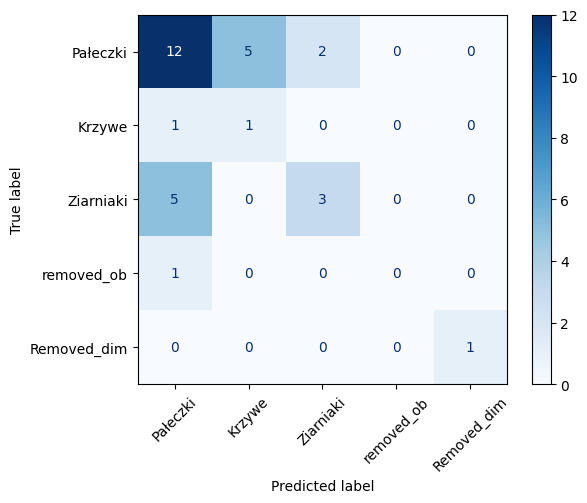

In [407]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [408]:
df_real = pd.read_csv("agata_1_y_real/raport_1_y_1.csv")
df_predicted = pd.read_csv("agata_1_y_no_model/a9_raport_no_model.csv")


In [409]:
df_real

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,długośćmm,szerokośćmm,kąt,obwódmm,...,średn._martinamm,średn._sitowamm,średnia_jaskrawość,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,1,164,937,16.4,93.7,10.26,4.301163,3.736308,72.41,13.124542,...,4.0,3.689173,234.0,130.5,179.5,190.5,165.4,15,100.0,12288.0
1,2,329,919,32.9,91.9,0.54,0.921954,0.565685,40.60,2.416741,...,0.9,0.640312,226.0,84.2,133.0,173.2,122.1,15,100.0,12288.0
2,4,1166,764,116.6,76.4,1.06,1.676305,0.824621,72.65,4.328347,...,0.6,0.921954,225.7,75.8,119.7,151.5,109.4,15,100.0,12288.0
3,5,294,668,29.4,66.8,0.86,1.220656,0.721110,34.99,3.238099,...,1.2,0.728011,229.1,91.8,147.6,180.2,133.8,15,100.0,12288.0
4,6,113,604,11.3,60.4,0.98,1.220656,0.860233,34.99,3.337303,...,1.1,0.900000,228.7,91.3,147.6,174.7,133.0,15,100.0,12288.0
5,7,456,585,45.6,58.5,3.30,3.140064,1.204159,99.16,7.491143,...,1.3,1.200000,238.3,94.4,149.8,181.4,136.0,15,100.0,12288.0
6,8,799,500,79.9,50.0,1.41,1.802776,0.921954,160.56,4.375796,...,1.6,0.943398,228.5,98.2,153.8,182.7,139.6,15,100.0,12288.0
7,9,987,407,98.7,40.7,0.84,1.236932,0.824621,14.04,3.470052,...,1.2,0.700000,226.5,107.0,164.0,185.1,148.5,15,100.0,12288.0
8,10,106,364,10.6,36.4,0.82,1.063015,0.848528,41.19,2.982316,...,1.0,0.894427,221.2,85.2,138.3,170.9,125.2,15,100.0,12288.0
9,11,449,256,44.9,25.6,2.29,2.529822,1.019804,161.57,6.229802,...,2.1,1.216553,236.4,99.6,154.6,184.5,140.7,15,100.0,12288.0


In [410]:
df_predicted

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,sredn._martinamm,sredn._sitowamm,srednia_jaskrawosc,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,1,163.5,933.0,16.4,93.3,8.78,3.7,3.2,9.27,11.788225,...,3.7,3.343508,205.1,173.9,217.2,224.7,205.1,1,30.1,30.8
1,2,328.5,919.5,32.9,92.0,0.45,0.9,0.5,9.69,2.614214,...,0.9,0.756940,120.0,85.7,129.6,160.9,120.0,1,7.8,7.3
2,3,1165.5,764.5,116.6,76.5,1.44,1.9,0.9,12.08,5.287006,...,1.9,1.351702,91.0,63.2,98.6,124.1,90.9,1,15.6,10.7
3,4,293.5,668.5,29.4,66.9,0.65,1.2,0.4,54.64,3.297056,...,1.2,0.909728,137.5,97.0,150.8,175.7,137.5,1,8.9,9.0
4,5,112.5,604.5,11.2,60.5,0.76,1.2,0.9,19.07,3.238478,...,1.2,0.980457,136.7,96.1,151.3,167.7,136.7,1,10.0,9.0
5,6,455.5,585.5,45.6,58.6,2.19,2.9,0.7,176.80,7.204163,...,2.9,1.667941,150.3,105.8,164.9,191.7,150.3,1,15.0,16.8
6,7,798.5,500.5,79.9,50.1,1.25,1.8,0.6,113.56,4.604163,...,1.8,1.259041,135.6,95.4,148.4,174.9,135.5,1,12.6,11.5
7,8,986.5,407.5,98.7,40.8,0.83,1.3,0.6,102.77,3.579899,...,1.3,1.028002,133.1,95.9,146.2,163.8,133.2,1,10.3,9.6
8,9,105.5,364.5,10.6,36.5,0.80,1.1,0.5,28.62,3.355635,...,1.1,1.006094,118.1,81.9,130.0,151.9,118.1,1,11.3,8.4
9,10,448.5,256.5,44.9,25.7,1.98,2.6,1.0,112.53,6.701219,...,2.6,1.585764,138.5,98.8,151.2,177.7,138.5,1,15.2,14.9


In [411]:
# df_predicted['powierzchniamm'] *= 1.1
# df_predicted['dlugoscmm'] *= 0.96
# df_predicted['szerokoscmm'] *= 0.96

In [412]:
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)
mean_abs_erron = np.mean(np.abs(compared['relative_error']))

real:
Shannon index: 0.8014159953485137
predicted:
Shannon index: 0.8364755496431736
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe           1                4      3        3.000000
1      Pałeczki           8                7     -1       -0.125000
2   Removed_dim           1                1      0        0.000000
3     Ziarniaki           3                1     -2       -0.666667


In [413]:
real_df['bacteria_type']

0     Removed_dim
1        Pałeczki
2        Pałeczki
3        Pałeczki
4       Ziarniaki
5        Pałeczki
6        Pałeczki
7       Ziarniaki
8       Ziarniaki
9        Pałeczki
10       Pałeczki
11         Krzywe
12       Pałeczki
Name: bacteria_type, dtype: object

In [414]:
predicted_df['bacteria_type']

0     Removed_dim
1        Pałeczki
2        Pałeczki
3        Pałeczki
4       Ziarniaki
5        Pałeczki
6        Pałeczki
7        Pałeczki
8        Pałeczki
9          Krzywe
10         Krzywe
11         Krzywe
12         Krzywe
Name: bacteria_type, dtype: object

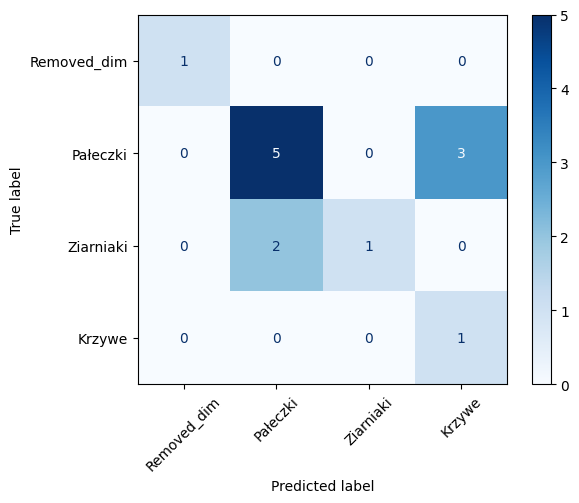

In [415]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [416]:
predicted_df.tail()

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,Pw,R,Dk,Sk,D/S,bacteria_type,Ob,bialko,wegiel,Ob_bucket
8,9,105.5,364.5,10.6,36.5,0.357942,0.738255,0.335570,28.62,3.355635,...,0.223526,0.624476,0.738255,0.335570,2.2,Pałeczki,0.055372,18.952041,16.298756,<=0.1
9,10,448.5,256.5,44.9,25.7,0.885906,1.744966,0.671141,112.53,6.701219,...,1.074276,1.212630,0.671141,0.859421,2.6,Krzywe,0.223032,43.117405,37.080969,0.2–0.5
10,11,1006.5,237.5,100.7,23.8,0.250559,0.805369,0.536913,21.64,3.014214,...,0.370434,1.478428,0.536913,0.296347,1.5,Krzywe,0.030205,13.254399,11.398783,<=0.1
11,12,978.5,188.5,97.9,18.9,0.720358,1.476510,0.671141,51.60,6.145584,...,0.894104,1.241194,0.671141,0.715283,2.2,Krzywe,0.173790,37.216154,32.005893,0.1–0.2
12,13,788.5,125.5,78.9,12.6,0.765101,1.812081,0.604027,83.44,6.628427,...,1.016103,1.328064,0.604027,0.812882,3.0,Krzywe,0.172765,37.086425,31.894326,0.1–0.2


In [417]:
predicted_df.tail()

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,Pw,R,Dk,Sk,D/S,bacteria_type,Ob,bialko,wegiel,Ob_bucket
8,9,105.5,364.5,10.6,36.5,0.357942,0.738255,0.335570,28.62,3.355635,...,0.223526,0.624476,0.738255,0.335570,2.2,Pałeczki,0.055372,18.952041,16.298756,<=0.1
9,10,448.5,256.5,44.9,25.7,0.885906,1.744966,0.671141,112.53,6.701219,...,1.074276,1.212630,0.671141,0.859421,2.6,Krzywe,0.223032,43.117405,37.080969,0.2–0.5
10,11,1006.5,237.5,100.7,23.8,0.250559,0.805369,0.536913,21.64,3.014214,...,0.370434,1.478428,0.536913,0.296347,1.5,Krzywe,0.030205,13.254399,11.398783,<=0.1
11,12,978.5,188.5,97.9,18.9,0.720358,1.476510,0.671141,51.60,6.145584,...,0.894104,1.241194,0.671141,0.715283,2.2,Krzywe,0.173790,37.216154,32.005893,0.1–0.2
12,13,788.5,125.5,78.9,12.6,0.765101,1.812081,0.604027,83.44,6.628427,...,1.016103,1.328064,0.604027,0.812882,3.0,Krzywe,0.172765,37.086425,31.894326,0.1–0.2
